In [2]:
from scipy.io import wavfile
from matplotlib import pyplot as plt
import numpy as np
import librosa
import scipy as sp

In [5]:
data_path = "../data/musicnet/musicnet/musicnet/train_data/"

In [6]:
rate, wav = wavfile.read(data_path + "1727.wav")

In [7]:
rate

44100

In [8]:
wav

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

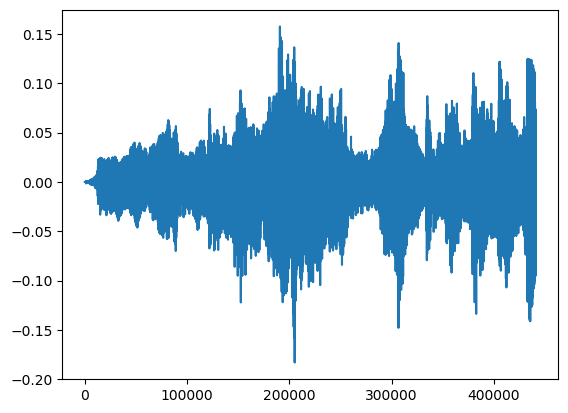

In [9]:
plt.plot(wav[0:rate*10])

In [10]:
n_fft = 2048
hop_length = 1024
mel = librosa.feature.melspectrogram(y=wav, sr=rate, n_fft=n_fft, hop_length=hop_length, fmax=8000)

In [11]:
mel_db = librosa.power_to_db(mel, ref=np.max)

In [13]:
mel_ = librosa.db_to_power(mel_db)

In [14]:
mel_db.shape

(128, 19254)

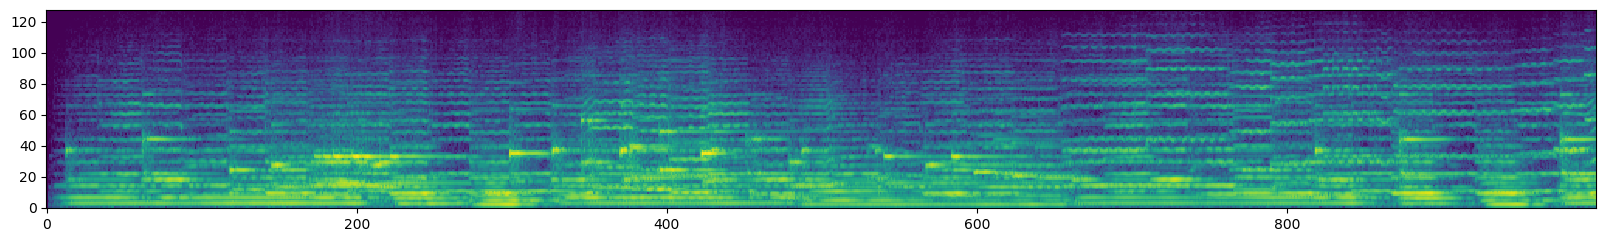

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(mel_db[:,:1000])
ax.invert_yaxis()

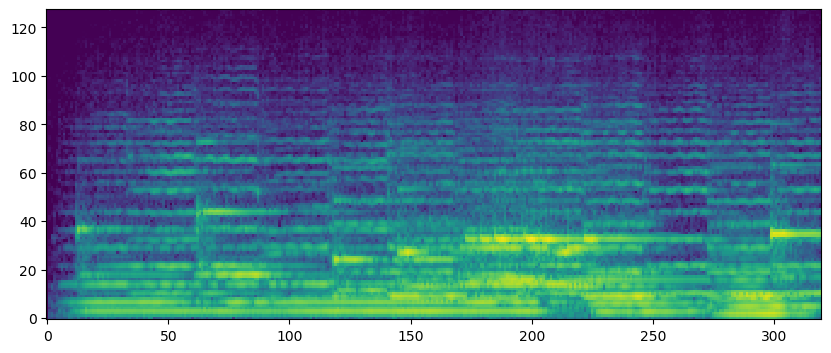

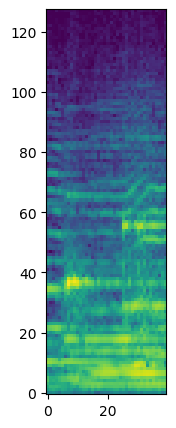

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(mel_db[:,0:320])
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(mel_db[:,320:360])
ax.invert_yaxis()

In [18]:
def normalize_mel(mel):
    return (mel + 80)/80
def unnormalize_mel(nmel):
    return nmel*80 - 80

In [19]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable, Function
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader

from time import time
import copy, math

In [20]:
block_size = 320

In [21]:
class music_data():
    def __init__(self, data, block_size):
        self.numpy = data
        self.block_size = block_size
        self.shape = data.shape
        self.data = []
        
    def init_data(self):
        for i in range(self.shape[1] - self.block_size):
            self.data.append(self.numpy[:, i:i+self.block_size])
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)

In [22]:
dataset = music_data(normalize_mel(mel_db), block_size)
dataset.init_data()
batch_size=32

In [23]:
dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

In [24]:
for i, batch in enumerate(dataloader):
    print(batch[0])
    print(batch[0].shape)
    break

tensor([[0.2858, 0.4042, 0.4141,  ..., 0.4564, 0.4230, 0.2943],
        [0.5522, 0.5871, 0.5540,  ..., 0.5783, 0.5612, 0.5839],
        [0.6708, 0.6901, 0.6674,  ..., 0.6873, 0.6924, 0.6962],
        ...,
        [0.0054, 0.0458, 0.0188,  ..., 0.0414, 0.0765, 0.0679],
        [0.0326, 0.0228, 0.0235,  ..., 0.0409, 0.0629, 0.0530],
        [0.0024, 0.0408, 0.0204,  ..., 0.0095, 0.0478, 0.0464]])
torch.Size([128, 320])


In [25]:
conv = nn.Conv1d(128, 128, 25, padding='same')

In [26]:
out = conv(batch[0].unsqueeze(0))

In [27]:
out.shape

torch.Size([1, 128, 320])

In [28]:
for i, batch in enumerate(dataloader):
    print(batch.shape)
    out = conv(batch)
    print(out.shape)
    break

torch.Size([32, 128, 320])
torch.Size([32, 128, 320])


In [29]:
class MusicModel(nn.Module):
    def __init__(self, d_model, kernel_size):
        super(MusicModel, self).__init__()
        self.d_model = d_model
        self.F1 = nn.Sequential(\
            nn.Conv1d(d_model, d_model//2, 2, stride=2),
            nn.ReLU(),
            nn.Conv1d(d_model//2, d_model//2, kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(d_model//2), 
            nn.Upsample(scale_factor=2, mode="linear"), 
            nn.Conv1d(d_model//2, d_model, kernel_size, padding='same'), 
            nn.ReLU(),
            nn.Conv1d(d_model, d_model, kernel_size, padding='same'),                    
        )
        self.F2 = copy.deepcopy(self.F1)
        self.F3 = copy.deepcopy(self.F1)
        self.F4 = copy.deepcopy(self.F1)
        
    def forward(self, x):
        y1 = self.F1(x)
        y2 = self.F2(x)
        y3 = self.F3(x)
        y4 = self.F4(x)
        return y1.pow(2) + y2.pow(2) + y3.pow(2) + y4.pow(2)

In [30]:
model = MusicModel(128, 25)

In [31]:
for batch in dataloader:
    out = model(batch)
    break

In [32]:
len(dataset) / batch_size

591.6875

In [33]:
d_model = 128
kernel_size = 25
device = torch.device('cuda')

In [34]:
model = MusicModel(d_model, kernel_size)
model.to(device)
crit = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [35]:
model.train()
for e in range(20):
    for i, x in enumerate(dataloader):
        x = x.to(device)
        y = torch.clone(x)
        pred = model(x)
        loss = crit(pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        if i % 100 == 0:
            print(loss.item())
    print(e)

0.14423291385173798
0.009153527207672596
0.008592060767114162
0.005942952819168568
0.005492031574249268
0.005445430520921946
0
0.004937466233968735
0.004370579030364752
0.004441084340214729
0.004085521679371595
0.0038752760738134384
0.004122160840779543
1
0.003768209833651781
0.0035689827054739
0.003509585279971361
0.0033933804370462894
0.003387295873835683
0.0030817107763141394
2
0.00366626912727952
0.0032069117296487093
0.0033490099012851715
0.0030689251143485308
0.0028765059541910887
0.002681145677343011
3
0.0027621218468993902
0.0029429292771965265
0.003363689174875617
0.002536042360588908
0.002592657692730427
0.0027805871795862913
4
0.0027653449214994907
0.0026998333632946014
0.002466436941176653
0.0024965812917798758
0.002863641595467925
0.0023660690058022738
5
0.002359689911827445
0.0024324916303157806
0.0024804805871099234
0.002302363980561495
0.0023983740247786045
0.0023981723934412003
6
0.00228576036170125
0.0021601764019578695
0.0021553044207394123
0.002117932541295886
0.002

In [36]:
model.eval()
model.to(device)
for x in dataloader:
    x = x.to(device)
    pred = model(x)
    break

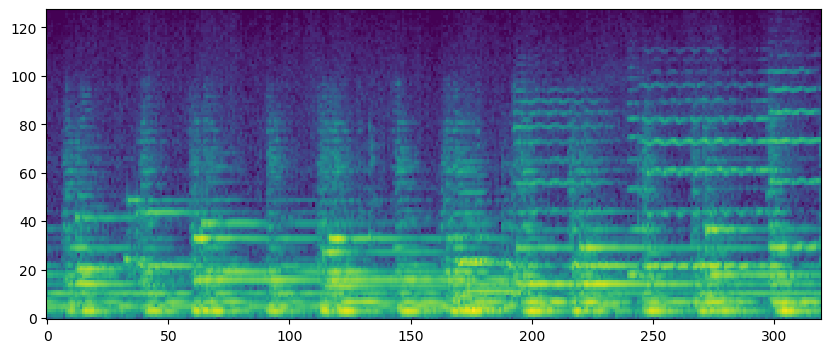

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(x[0].cpu().numpy())
ax.invert_yaxis()

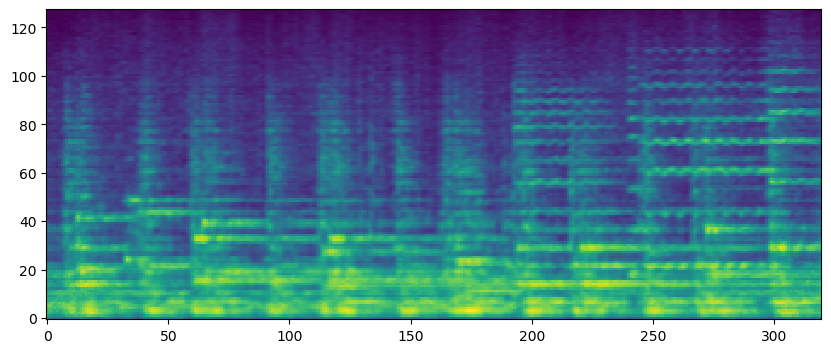

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(pred[0].detach().cpu().numpy())
ax.invert_yaxis()

In [39]:
y1 = model.F1(x)[0].pow(2).detach().cpu().numpy()
y2 = model.F2(x)[0].pow(2).detach().cpu().numpy()
y3 = model.F3(x)[0].pow(2).detach().cpu().numpy()
y4 = model.F4(x)[0].pow(2).detach().cpu().numpy()

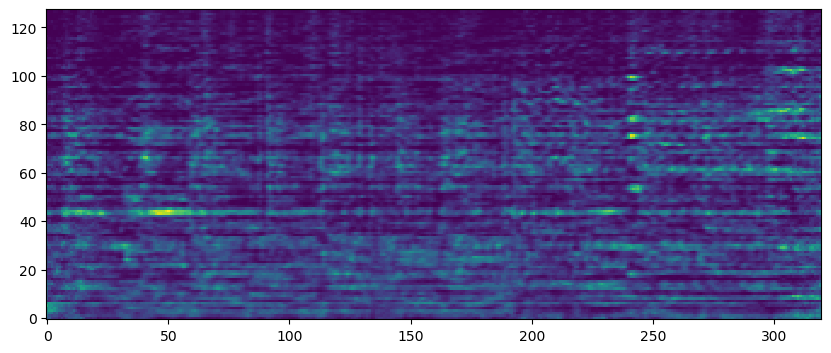

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y1)
ax.invert_yaxis()

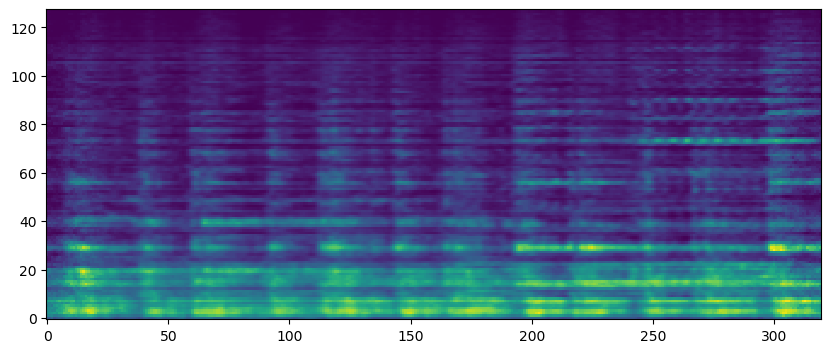

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y2)
ax.invert_yaxis()

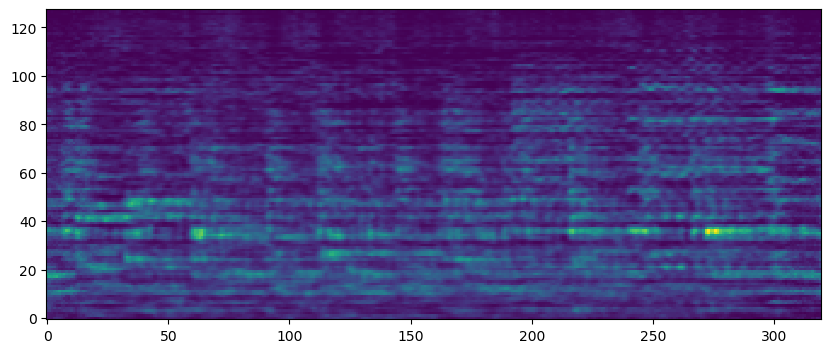

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y3)
ax.invert_yaxis()

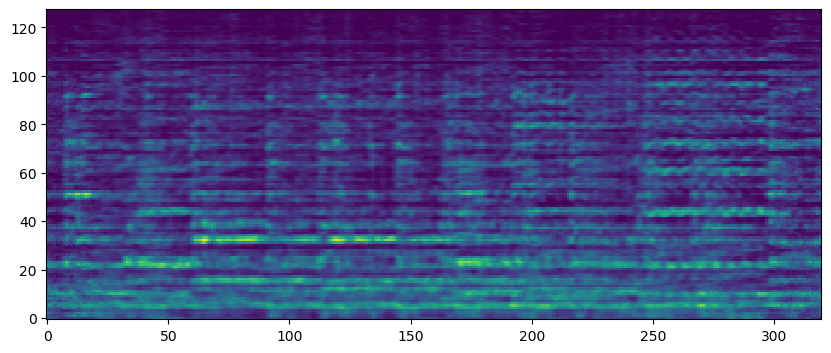

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y4)
ax.invert_yaxis()

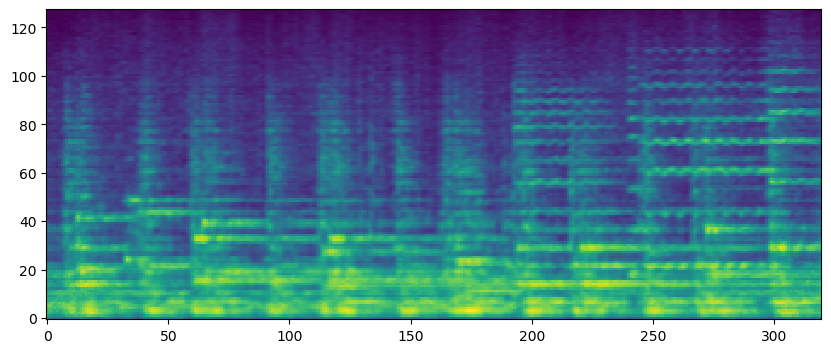

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y1 + y2 + y3 + y4)
ax.invert_yaxis()

In [45]:
full_aud = torch.tensor(normalize_mel(mel_db)).unsqueeze(0)

In [46]:
full_aud.shape

torch.Size([1, 128, 19254])

In [47]:
model.eval()
with torch.no_grad():
    y1_out = model.F1(full_aud.to(device)).pow(2)
    y2_out = model.F2(full_aud.to(device)).pow(2)
    y3_out = model.F3(full_aud.to(device)).pow(2)
    y4_out = model.F4(full_aud.to(device)).pow(2)

In [48]:
y1_out = y1_out.cpu()
y2_out = y2_out.cpu()
y3_out = y3_out.cpu()
y4_out = y4_out.cpu()

In [49]:
y1_out.shape, y2_out.shape, y3_out.shape, y4_out.shape

(torch.Size([1, 128, 19254]),
 torch.Size([1, 128, 19254]),
 torch.Size([1, 128, 19254]),
 torch.Size([1, 128, 19254]))

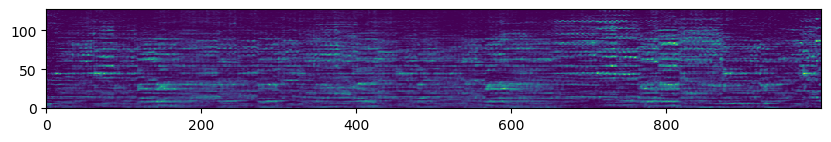

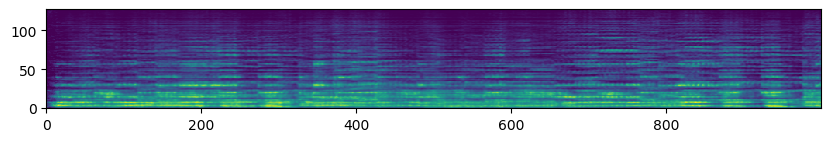

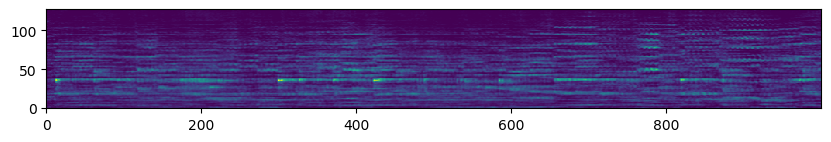

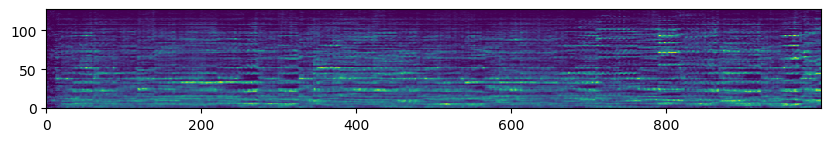

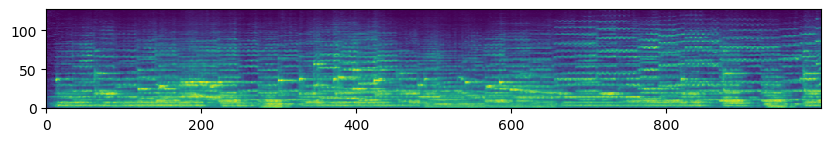

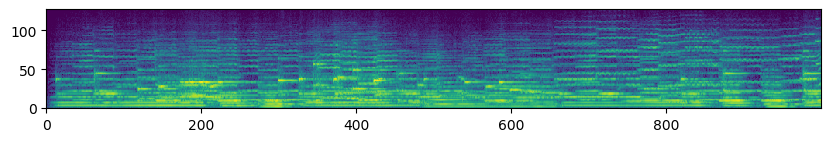

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y1_out[0,:,:1000])
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y2_out[0,:,:1000])
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y3_out[0,:,:1000])
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y4_out[0,:,:1000])
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow((y1_out+y2_out+y3_out+y4_out)[0,:,:1000])
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(mel_db[:,:1000])
ax.invert_yaxis()

In [51]:
torch.cuda.empty_cache()

In [52]:
mel_y1_out = y1_out.squeeze().numpy()
mel_y2_out = y2_out.squeeze().numpy()
mel_y3_out = y3_out.squeeze().numpy()
mel_y4_out = y4_out.squeeze().numpy()
mel_out = mel_y1_out + mel_y2_out + mel_y3_out + mel_y4_out

In [53]:
mel_y1_out = unnormalize_mel(mel_y1_out)
mel_y2_out = unnormalize_mel(mel_y2_out)
mel_y3_out = unnormalize_mel(mel_y3_out)
mel_y4_out = unnormalize_mel(mel_y4_out)
mel_out = unnormalize_mel(mel_out)

In [54]:
mel_y1_out = librosa.db_to_power(mel_y1_out)
mel_y2_out = librosa.db_to_power(mel_y2_out)
mel_y3_out = librosa.db_to_power(mel_y3_out)
mel_y4_out = librosa.db_to_power(mel_y4_out)
mel_out = librosa.db_to_power(mel_out)

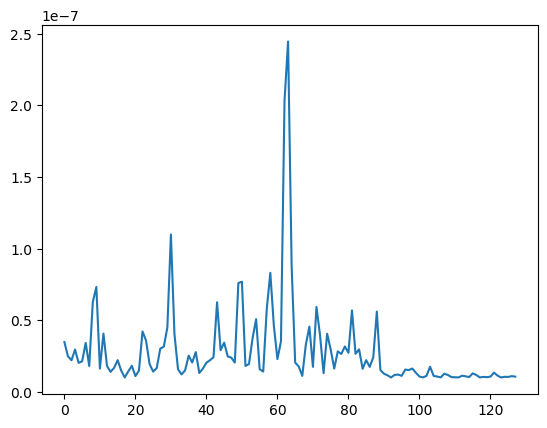

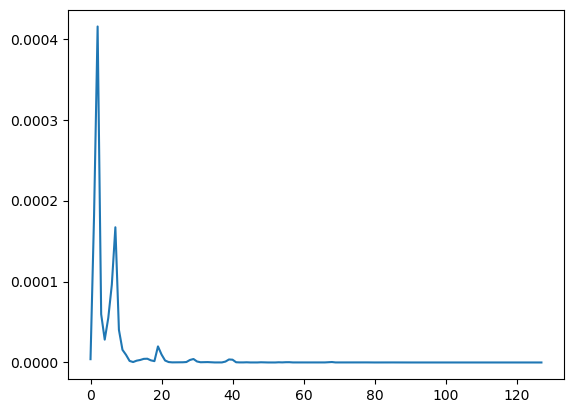

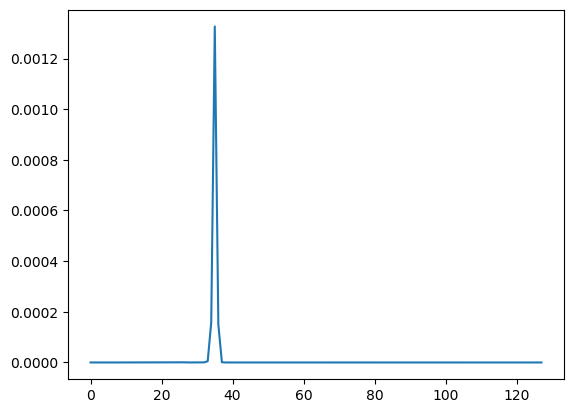

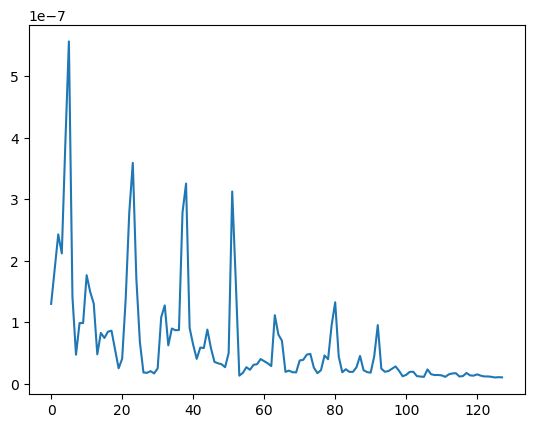

[]

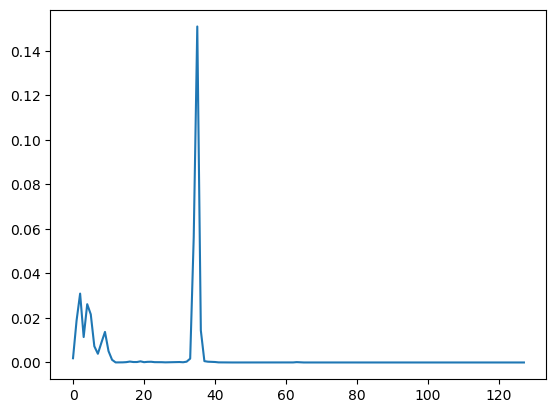

In [55]:
plt.plot(mel_y1_out[:,300])
plt.show()
plt.plot(mel_y2_out[:,300])
plt.show()
plt.plot(mel_y3_out[:,300])
plt.show()
plt.plot(mel_y4_out[:,300])
plt.show()
plt.plot(mel_out[:,300])
plt.plot()

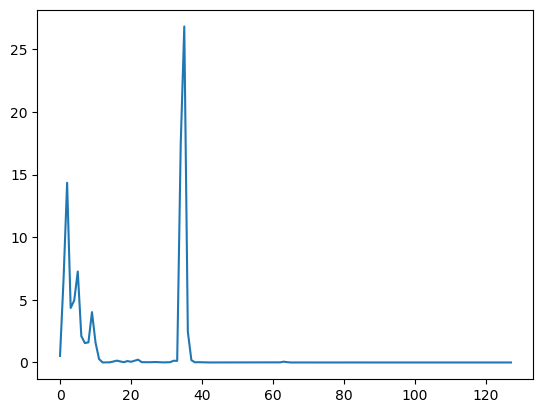

In [56]:
plt.plot(mel[:,300])

In [57]:
wav_out = librosa.feature.inverse.mel_to_audio(mel_out, sr=rate, hop_length=hop_length, fmax=8000)

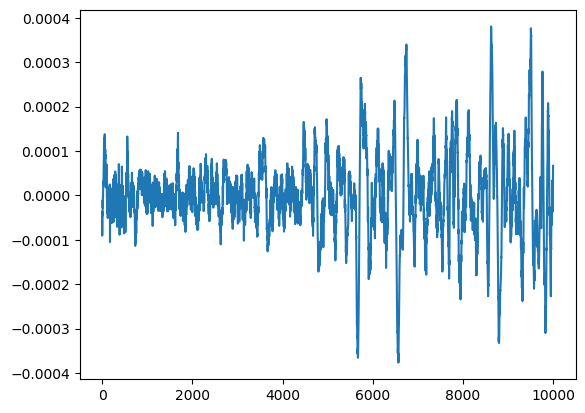

In [58]:
plt.plot(wav_out[:10000])

In [59]:
sp.io.wavfile.write("outputs/1727_conv_out1.wav", rate, wav_out)

In [60]:
wav_y1_out = librosa.feature.inverse.mel_to_audio(mel_y1_out, sr=rate, hop_length=hop_length, fmax=8000)

In [61]:
wav_y2_out = librosa.feature.inverse.mel_to_audio(mel_y2_out, sr=rate, hop_length=hop_length, fmax=8000)

In [62]:
wav_y3_out = librosa.feature.inverse.mel_to_audio(mel_y3_out, sr=rate, hop_length=hop_length, fmax=8000)

In [63]:
wav_y4_out = librosa.feature.inverse.mel_to_audio(mel_y4_out, sr=rate, hop_length=hop_length, fmax=8000)

In [64]:
sp.io.wavfile.write("outputs/1727_conv_y1_out3.wav", rate, wav_y1_out)
sp.io.wavfile.write("outputs/1727_conv_y2_out3.wav", rate, wav_y2_out)
sp.io.wavfile.write("outputs/1727_conv_y3_out3.wav", rate, wav_y3_out)
sp.io.wavfile.write("outputs/1727_conv_y4_out3.wav", rate, wav_y4_out)